In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaForSequenceClassification, AutoTokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

In [2]:
torch.manual_seed(100)

In [3]:
n_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class ReviewDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        text = self.X.iloc[idx]
        y = self.y.iloc[idx]

        # Tokenize text input for model compatibility
        inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)

        return inputs['input_ids'].squeeze(), inputs['attention_mask'].squeeze(), torch.tensor(y, dtype=torch.long)

In [5]:
# Read in scale reviews dataset
data_path = 'drive/MyDrive/UMD/MSML641/Project/Data/CornellMovieReview_scale_data'

train_reviews = pd.read_csv(f'{data_path}/MovieReviewScaleData_Train_PolarityValence.csv')
val_reviews = pd.read_csv(f'{data_path}/MovieReviewScaleData_Val_PolarityValence.csv')
test_reviews = pd.read_csv(f'{data_path}/MovieReviewScaleData_Test_PolarityValence.csv')

batch_size = 128

# Initialize dataloaders. Need tokenizer. Use pretrained distilBERT tokenizer for corresponding model.
#tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
train_reviews = ReviewDataset(train_reviews['Review'],train_reviews['Rating'], tokenizer)
train_dataloader = DataLoader(train_reviews, batch_size=batch_size, shuffle=True)

val_reviews = ReviewDataset(val_reviews['Review'],val_reviews['Rating'], tokenizer)
val_dataloader = DataLoader(val_reviews, batch_size=batch_size, shuffle=False)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [25]:
# Initialize model
#model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-emotion")
model = RobertaForSequenceClassification.from_pretrained("roberta-base")
# Replace the final layer to have correct number of outputs
model.classifier.out_proj = nn.Linear(in_features = 768, out_features = 11, bias = True)
model.to(device)

for param in model.parameters():
    param.requires_grad = False

for param in model.roberta.encoder.layer[-2:].parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [27]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []

n_epochs = 15

# Train the model
model.train()
for epoch in tqdm(range(n_epochs)):
    correct_train = 0
    correct_val = 0
    total_train_samples = 0
    total_val_samples = 0
    epoch_loss_train = 0
    epoch_loss_val = 0

    #if epoch == 5: # Stop tuning transformer here, continue with just classifier head
    #    for param in model.roberta.encoder.layer[-2:].parameters():
    #        param.requires_grad = False

    # Train the model
    for input_ids, attention_mask, labels in train_dataloader:

        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        pred = model(input_ids, attention_mask).logits

        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        epoch_loss_train += loss.item()

        # Calculate accuracy for current batch
        pred = pred.argmax(dim=1)

        correct_train += (pred == labels).sum().item()
        total_train_samples += labels.size(0)

        del input_ids, attention_mask, labels, pred, loss

    train_loss.append(epoch_loss_train)
    train_accuracy = (correct_train / total_train_samples) * 100
    train_acc.append(train_accuracy)

    # Validate
    with torch.no_grad():
        model.eval()

        for input_ids, attention_mask, labels in val_dataloader:

            input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
            labels = labels.to(device)

            pred = model(input_ids, attention_mask).logits

            loss = criterion(pred, labels)
            epoch_loss_val += loss.item()

            # Calculate accuracy for current batch
            pred = pred.argmax(dim=1)

            correct_val += (pred == labels).sum().item()
            total_val_samples += labels.size(0)

            del input_ids, attention_mask, labels, pred, loss

    val_loss.append(epoch_loss_val)
    val_accuracy = (correct_val / total_val_samples) * 100
    val_acc.append(val_accuracy)

    print(f"Epoch {epoch+1}, Train Accuracy: {round(train_accuracy,5)}, Validation Accuracy: {round(val_accuracy,5)}")

  7%|▋         | 1/15 [00:48<11:14, 48.21s/it]

Epoch 1, Train Accuracy: 17.8653, Validation Accuracy: 21.97802


 13%|█▎        | 2/15 [01:32<09:59, 46.12s/it]

Epoch 2, Train Accuracy: 20.63356, Validation Accuracy: 25.47453


 20%|██        | 3/15 [02:18<09:10, 45.85s/it]

Epoch 3, Train Accuracy: 27.02626, Validation Accuracy: 28.67133


 27%|██▋       | 4/15 [03:03<08:21, 45.57s/it]

Epoch 4, Train Accuracy: 29.45205, Validation Accuracy: 27.47253


 33%|███▎      | 5/15 [03:49<07:35, 45.55s/it]

Epoch 5, Train Accuracy: 36.9863, Validation Accuracy: 30.86913


 40%|████      | 6/15 [04:34<06:48, 45.41s/it]

Epoch 6, Train Accuracy: 43.40753, Validation Accuracy: 28.57143


 47%|████▋     | 7/15 [05:19<06:04, 45.53s/it]

Epoch 7, Train Accuracy: 48.68721, Validation Accuracy: 30.96903


 53%|█████▎    | 8/15 [06:05<05:18, 45.46s/it]

Epoch 8, Train Accuracy: 55.3653, Validation Accuracy: 29.67033


 60%|██████    | 9/15 [06:50<04:32, 45.50s/it]

Epoch 9, Train Accuracy: 56.33562, Validation Accuracy: 28.67133


 67%|██████▋   | 10/15 [07:36<03:47, 45.41s/it]

Epoch 10, Train Accuracy: 66.21005, Validation Accuracy: 28.17183


 73%|███████▎  | 11/15 [08:21<03:01, 45.40s/it]

Epoch 11, Train Accuracy: 68.97831, Validation Accuracy: 31.66833


 80%|████████  | 12/15 [09:06<02:15, 45.33s/it]

Epoch 12, Train Accuracy: 70.00571, Validation Accuracy: 30.06993


 87%|████████▋ | 13/15 [09:51<01:30, 45.33s/it]

Epoch 13, Train Accuracy: 69.09247, Validation Accuracy: 31.06893


 93%|█████████▎| 14/15 [10:37<00:45, 45.28s/it]

Epoch 14, Train Accuracy: 75.17123, Validation Accuracy: 31.06893


100%|██████████| 15/15 [11:22<00:00, 45.50s/it]

Epoch 15, Train Accuracy: 79.13813, Validation Accuracy: 29.17083


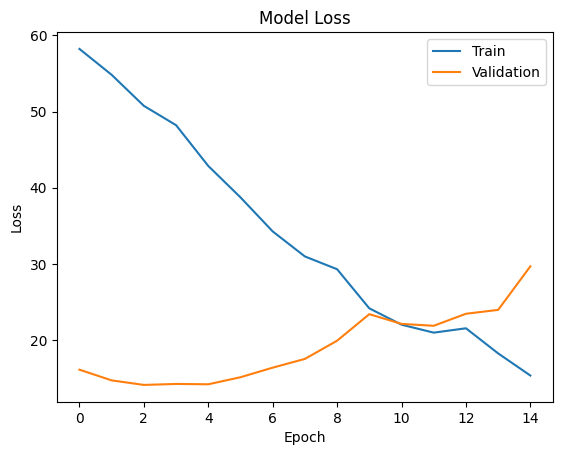

In [28]:
plt.title('Model Loss')
plt.plot([i for i in range(n_epochs)], train_loss, label='Train')
plt.plot([i for i in range(n_epochs)], val_loss, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.close()

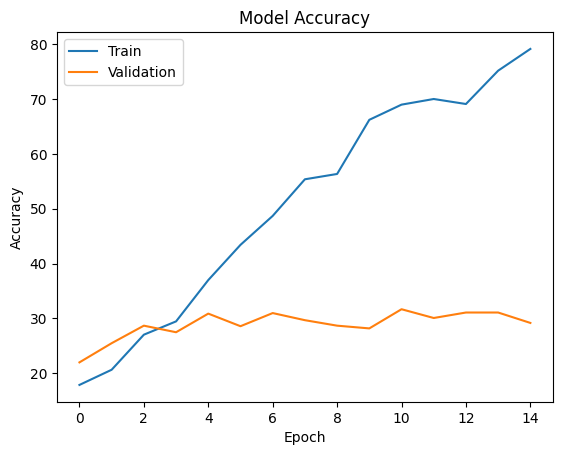

In [29]:
plt.title('Model Accuracy')
plt.plot([i for i in range(n_epochs)], train_acc, label='Train')
plt.plot([i for i in range(n_epochs)], val_acc, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.close()

In [30]:
import numpy as np
# Validate
with torch.no_grad():
    model.eval()

    i=0
    for input_ids, attention_mask, labels in val_dataloader:

        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        labels = labels.to(device)

        pred = model(input_ids, attention_mask).logits

        loss = criterion(pred, labels)
        val_loss.append(loss.item())

        # Calculate accuracy for current batch
        pred = pred.argmax(dim=1)

        correct_val += (pred == labels).sum().item()
        total_val_samples += labels.size(0)

        if i == 0:
            all_pred = pred.cpu().detach().numpy()
            all_labels = labels.cpu().detach().numpy()
            i+=1
        else:
            all_pred = np.concatenate([all_pred,pred.cpu().detach().numpy()])
            all_labels = np.concatenate([all_labels,labels.cpu().detach().numpy()])

        del input_ids, attention_mask, labels, pred, loss

val_accuracy = (correct_val / total_val_samples) * 100
print(f"Final validation accuracy:", val_accuracy)

Final validation accuracy: 29.170829170829172


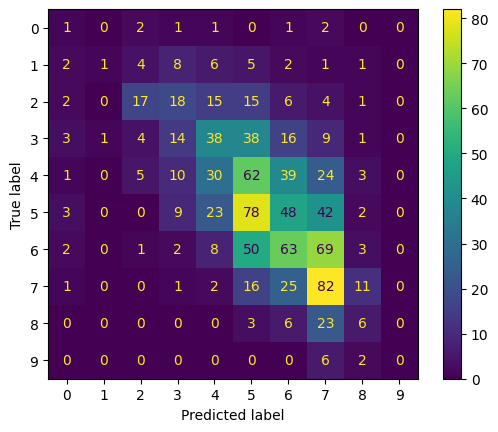

In [31]:
cm = confusion_matrix(all_labels, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [32]:
f1_score(all_labels, all_pred, average='weighted')

0.27270079822748017

# Get test results

In [33]:
test_reviews = ReviewDataset(test_reviews['Review'],test_reviews['Rating'], tokenizer)
test_dataloader = DataLoader(test_reviews, batch_size=batch_size, shuffle=False)

In [34]:
import numpy as np
# Validate
with torch.no_grad():
    model.eval()

    test_loss = []
    correct_test = 0
    total_test_samples = 0
    i=0
    for input_ids, attention_mask, labels in test_dataloader:

        input_ids, attention_mask = input_ids.to(device), attention_mask.to(device)
        labels = labels.to(device)

        pred = model(input_ids, attention_mask).logits

        loss = criterion(pred, labels)
        test_loss.append(loss.item())

        # Calculate accuracy for current batch
        pred = pred.argmax(dim=1)

        correct_test += (pred == labels).sum().item()
        total_test_samples += labels.size(0)

        if i == 0:
            all_pred = pred.cpu().detach().numpy()
            all_labels = labels.cpu().detach().numpy()
            i+=1
        else:
            all_pred = np.concatenate([all_pred,pred.cpu().detach().numpy()])
            all_labels = np.concatenate([all_labels,labels.cpu().detach().numpy()])

        del input_ids, attention_mask, labels, pred, loss

test_accuracy = (correct_test / total_test_samples) * 100
print(f"Test Accuracy:", test_accuracy)

Test Accuracy: 32.33532934131736


Test confusion matrix

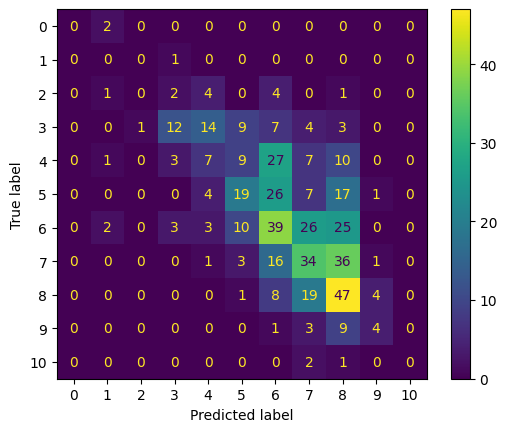

In [35]:
cm = confusion_matrix(all_labels, all_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Testing F1 score

In [37]:
f1_score(all_labels, all_pred,average='weighted')

0.30738288572542916